In [53]:
import jax
import jax.numpy as jnp
from typing import Callable, Tuple
import logging
from NN import create_nn
from optim import create_cbo
import numpy as np
from gen_config import generate_configure
import argparse
from scipy.stats import binned_statistic_2d,binned_statistic
import matplotlib.pyplot as plt

In [93]:
dim = 1
config  = generate_configure(dim)
problem_configure = config['problem']
init, apply = create_nn(1,**config["NN"])
config["sde"]["N_step"] = 100
config["sde"]["N_sample"] = 10000
config["sde"]["N_mv"] = 1000
N_mv = config["sde"]["N_mv"]

In [94]:

# Compute the loss function
def generate_control_loss(
    fcn_g: Callable =  lambda x : x,
    fcn_f: Callable = lambda x : x,
    x_start: jnp.ndarray = jnp.zeros(2),
    N_step: int = 10,
    N_sample: int = 10,
    N_mv: int = 10,
    problem_configure: dict = None,
):
    
    T0 = problem_configure["T0"]
    T1 = problem_configure["T1"]
    dim = problem_configure["dim"]
    k = problem_configure["k"]
    q = problem_configure["q"]
    def compute_loss(
        rng: jax.random.PRNGKey, 
        params: dict, 
        x_start_new: jnp.ndarray = jnp.zeros(2), 
        T0_new: float = 0.0
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        # x = x_start_new[None, None, ...].repeat(N_sample, axis=0).repeat(N_mv, axis=1)
        x_start_new = 0.1*jax.random.normal(rng, shape=(N_sample, N_mv, dim))
        x = jnp.copy(x_start_new)
        t = jnp.linspace(T0_new, T1, N_step + 1).reshape(-1, 1)
        dt = t[1] - t[0]
        loss = jnp.zeros(N_sample)
        for i in range(N_step+1):
            rng, key = jax.random.split(rng)
            t_current = t[i][None, None, ...].repeat(N_sample, axis=0).repeat(N_mv, axis=1)
            input = jnp.concatenate([x, t_current], axis=-1)
            dis = apply(params["distribution"], input)
            dis_mean = jnp.mean(dis, axis=1,keepdims=True).repeat(N_mv, axis=1)
            input = jnp.concatenate([dis_mean, x, t_current], axis=-1)
            m = apply(params["control"], input)
            x_mean = x.mean(axis=1, keepdims=True)
            Qt = problem_configure["fcn_Q"](t[i])
            m2 = (q+2*Qt)*(x_mean-x)
            loss += fcn_f(x,m) * dt
            if i == 0:
                m0 = jnp.copy(m)
                m1 = jnp.copy(m2)
            x = x + dt *( k*(x_mean - x) + m) + jnp.sqrt(dt)  * jax.random.normal(key, shape=(N_sample, N_mv, dim))
            # x = x + 2 * dt * m + jnp.sqrt(2 * dt) * jax.random.normal(rng, shape=(N_sample, dim))
        loss += fcn_g(x)
        return loss,x_start_new,m0,m1
    
    return compute_loss





In [95]:


compute_loss = generate_control_loss(**config["sde"])
params_old = init(jax.random.PRNGKey(0))



params= np.load(f"./result_{dim}/params.npy", allow_pickle=True)
params_new_all = {}
for key_params in params.any().keys():
    params_new = []
    print(key_params)
    for params_i in params.any()[key_params]:
        for key in params_i.keys():
            params_i[key] = params_i[key][0,0,...]
        params_new.append(params_i)
    params_new_all[key_params] = params_new
rng = jax.random.PRNGKey(100)


control
distribution


In [96]:
x = np.linspace(0,1,100)
value_test1,x_start_new,m0,m1 =  jax.vmap(lambda x: compute_loss(rng,params_new_all, jnp.zeros(1), x))(x)


In [97]:
# x

Array([0.        , 0.11111111, 0.22222222, 0.33333334, 0.44444445,
       0.5555556 , 0.6666667 , 0.7777778 , 0.8888889 , 1.        ],      dtype=float32)

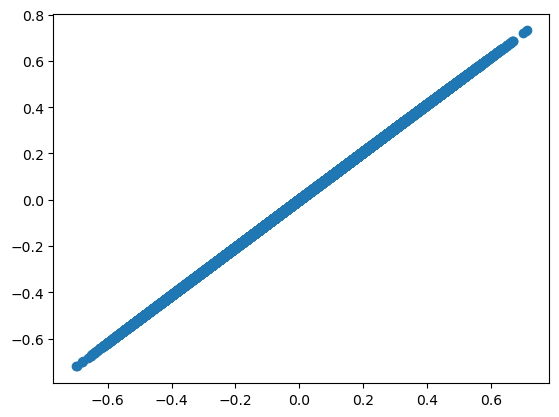

In [98]:
# plt.plot(m0.reshape(-1),m1.reshape(-1),'o')

In [99]:
# value_test1.shape

(10000,)

In [100]:
value, x_edges,_  = binned_statistic(x_start_new[:,:,0].reshape(-1),value_test1[:][...,None].repeat(N_mv,axis=-1).reshape(-1),statistic='mean',bins=20)
x_min = x_edges[:-1]+(x_edges[1]-x_edges[0])/2

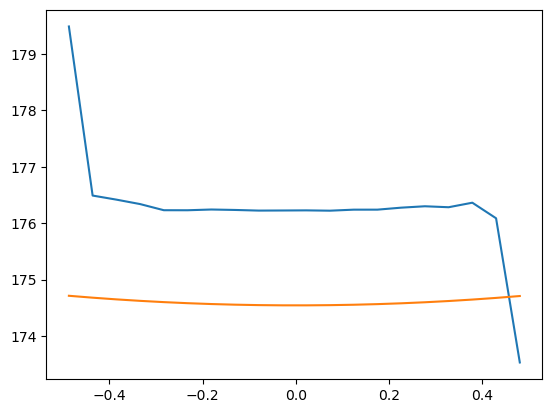

In [101]:
# plt.plot(x_min,value)
# Qt = problem_configure["fcn_Q"](0.8)
# Qs = problem_configure["fcn_Qs"](0.8)
# plt.plot(x_min,(x_min)**2*Qt + N_mv*Qt*0.01 + N_mv*Qs)

In [48]:
# Qs

In [49]:
# nabla_value = np.gradient(value,x_edges[:-1])

In [50]:
# q = problem_configure["q"]
# plt.plot(x_start_new[0,:,0,0],m0[0,:,0,0],'.')
# # plt.plot(x_edges[:-1],-(q+2*Qt)*(x_edges[:-1]))

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

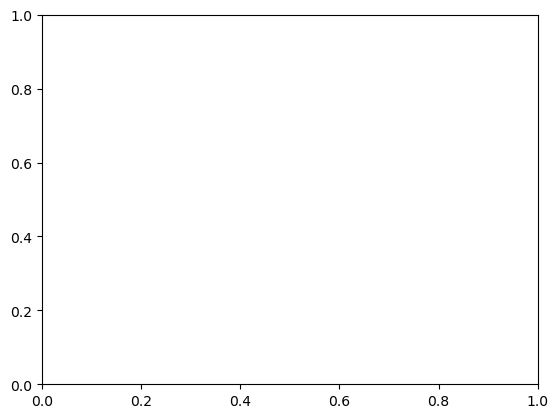

In [51]:
import matplotlib.pyplot as plt
plt.plot(x,value_test1.mean(axis=-1))
problem_configure = config["sde"]["problem_configure"]
plt.plot(x,problem_configure["fcn_Qs"](x)*N_mv+N_mv*problem_configure["fcn_Q"](x)*0.01)

In [14]:
# problem_configure["fcn_Qs"](x)*N_mv+N_mv*problem_configure["fcn_Q"](x)*1

In [15]:
# value_test1.mean(axis=-1)